In [1]:
!python --version

Python 3.9.7


In [ ]:
!pip install fastmri

In [3]:
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import zoom
import fastmri
import torch
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc
import pywt
import warnings
from PIL import Image
from IPython import display

## Data util functions

In [4]:
def data_GT(path):
  '''
  Load Ground truth kspace and images of all slices from given path
  '''
  data = dict()
  data['kspace'] = []

  volumes = []
  for file in os.listdir(path):
    file_name = os.path.join(path, file)
    hf = h5py.File(file_name)
    volume_kspace = hf['kspace'][()]
    data['kspace'].append(volume_kspace)
    vol, _, _ = volume_kspace.shape
    volumes.append(vol)


  data['slice_img'] = []
  for i in range(len(data['kspace'])):
        
    slice_kspace2 = T.to_tensor(data['kspace'][i])      # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image

    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    data['slice_img'].append(slice_image_abs)

  return data

In [5]:
def subsample_data(dataGT):
  '''
  downsampling/compressed sensing the data by multiplying with mask
  '''
  mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[4])  # Create the mask function object
  masked_kspace, mask = T.apply_mask(torch.tensor(dataGT['kspace'][0]), mask_func)   # Apply the mask to k-space
  #%%
  dataGT['masked_img'] = []
  dataGT['masked_kspace'] = []
  for i in range(len(dataGT['kspace'])):
        
    slice_kspace2 = T.to_tensor(dataGT['kspace'][i])      # Convert from numpy array to pytorch tensor
    
    mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[4])  # Create the mask function object
    masked_kspace, mask = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
    dataGT['masked_kspace'].append(masked_kspace)
    slice_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    dataGT['masked_img'].append(slice_image_abs)

    return dataGT, mask

# **Objective function** 

In [6]:
from scipy.fftpack import dct, idct
from scipy.optimize import minimize

def TV(img, weight):      
    tv_h = ((img[1:,:] - img[:-1,:])**2).sum()
    tv_w = ((img[:,1:] - img[:,:-1])**2).sum()    
    return weight * (tv_h + tv_w)


def obj_fn(x, y, u, l):
  #error constraint
  #print(x.shape, y.shape, u.shape, l)
  x = x.reshape(y.shape)
  term1 = np.linalg.norm(np.fft.fftshift(np.fft.fft2(x)) * u - y)**2
  
  #l1 constraint
  term2 = np.linalg.norm(dct(dct(x.T, norm='ortho').T, norm='ortho'), ord=1)
  #regularizer

  return term1+l*term2

def obj_fnTV(x, y, u, l1, l2=0.1):
  #error constraint
  #print(x.shape, y.shape, u.shape, l)
  x = x.reshape(y.shape)
  term1 = np.linalg.norm(np.fft.fftshift(np.fft.fft2(x)) * u - y)**2
  
  #l1 constraint
  term2 = np.linalg.norm(dct(dct(x.T, norm='ortho').T, norm='ortho'), ord=1)
  #regularizer

  return term1+l1*term2+l2*TV(x, l2)

In [7]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                 
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

## Load data

In [8]:

path = "data/"

data = data_GT(path)
print(data['kspace'][0].shape, data['kspace'][0].dtype)
print(data['slice_img'][0].shape, data['slice_img'][0].dtype)
dataCS, U = subsample_data(data)


(35, 640, 368) complex64
torch.Size([35, 640, 368]) torch.float32


In [9]:
xtrue_vol = np.array(dataCS['slice_img'][0])
y_vol = np.array(dataCS['masked_kspace'][0][:,:, :, 0]) + 1j* np.array(dataCS['masked_kspace'][0][:,:, :, 1])
print(xtrue_vol.shape, y_vol.shape)

#choose one 2d slice for experimentation

xtrue = xtrue_vol[15]   #.reshape(-1,1)
y = y_vol[15]    #.reshape(-1, 1)
u = U[0, 0, :, 0].numpy()
print(xtrue.shape, y.shape)

(35, 640, 368) (35, 640, 368)
(640, 368) (640, 368)


## Generate mask U

In [10]:
psize = 16
S = int(psize//(10)) #10% sparse
q = np.random.permutation(psize)
patch_u = np.zeros(psize)
patch_u[q[:S]] = 1

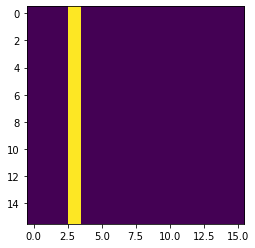

In [11]:
mat = np.repeat(patch_u.reshape(-1,1), 16, 1)
plt.imshow(mat.T)
plt.show()

# Patchwise reconstruction with NL-CGD

In [ ]:
#choose one 2d slice for experimentation
xtrue_vol = np.array(dataCS['slice_img'][0])

xtrue = xtrue_vol[15]   #.reshape(-1,1)
R, C = xtrue.shape
#30% sparse
S = int(psize//(10))
q = np.random.permutation(psize)
patch_u = np.zeros(psize)
patch_u[q[:S]] = 1
lamda = 0.1

#xmin = xtrue.min()
#xmax = xtrue.max()
#xtrue = (xtrue-xmin)/(xmax-xmin)
xpred = np.zeros((R, C))
x_under = np.zeros((R, C))
for i in range(0,R, psize ):
  for j in range(0, C, psize):
    patch_x = xtrue[i:i+psize, j:j+psize] #extract patch
    xmin = patch_x.min()
    xmax = patch_x.max()
    patch_x = (patch_x-xmin)/(xmax-xmin) #normalize
    patch_y = patch_u*np.fft.fftshift(np.fft.fft2(patch_x))
    
    x_under[i:i+psize, j:j+psize] = np.real(np.fft.ifft2(np.fft.ifftshift(patch_y))) * (xmax-xmin) + xmin #naive reconstrcution with IFFT

    x0 = np.zeros((psize, psize))
    min_result = minimize(obj_fnTV, x0,  args = ( patch_y,patch_u, lamda), method='CG', options={'maxiter' : 250})   #NLCGD step

    patch_pred = min_result['x'].reshape(psize, psize)    
    
    if j==0:
      print(i/psize, j/psize, min_result["success"], obj_fnTV(x0, patch_y, patch_u, lamda), obj_fn(patch_pred, patch_y, patch_u, lamda) )
    patch_pred = patch_pred*(xmax-xmin) + xmin
    xpred[i:i+psize, j:j+psize] = patch_pred 
  
#xpred = x_pred*(xmax-xmin) + xmin
print('Error between GT and Recon = ', np.linalg.norm(xpred-xtrue)**2, 'PSNR = ', PSNR(xtrue, xpred))

In [ ]:
#visualize results
f, ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(xtrue)
ax[0].set_title("ground truth")
ax[1].imshow(x_under)
ax[1].set_title("undersampled IFFT")
ax[2].imshow(xpred)
ax[2].set_title("reconstruction")
plt.show()

In [ ]:
xtrue = (xtrue - xtrue.min())/(xtrue.max() - xtrue.min())
xpred = (xpred - xpred.min())/(xpred.max() - xpred.min())
print('Error between GT and Recon = ',np.mean((xpred-xtrue)**2), 'PSNR = ', PSNR(xtrue*255, xpred*255))

# Trial experiment

In [ ]:
psize = 16
x = np.random.randn(psize,psize)
x = (x - np.min(x))/(np.max(x) - np.min(x))
u = np.sign(np.random.randn(psize))
u[u<0] = 0
xfft = np.fft.fftshift(np.fft.fft2(x))
y = u*xfft

'''
plt.imshow(x)
plt.colorbar()
plt.show()


plt.stem(u)
plt.show()


plt.imshow(np.abs(xfft))
plt.colorbar()
plt.show()


plt.imshow(np.abs(y))
plt.colorbar()
plt.show()
'''
lamda = 0.1
print("Least attainable value of obj func = ",  obj_fn(x, y, u, lamda))
min_result = minimize(obj_fn, x0,  args = ( y, u, lamda), method='CG', options={'maxiter' : 1000})
xpred = min_result['x'].reshape(psize, psize)
print('Reconstruction success: ', min_result['success'], 'Final value of obj func = ', obj_fn(xpred, y, u, lamda))
print('Error between GT and Recon = ', np.linalg.norm(xpred-x)**2)

# Implementation of soft thresholding


In [17]:
def SoftThresh(y, t):
    x_hat = (y / np.abs(y)) * np.maximum(np.abs(y)-t, 0)
    return x_hat

In [ ]:
x_norm = (xtrue - xtrue.min())/(xtrue.max() - xtrue.min()) #normalise the image

In [19]:
mri_fourier_n = np.fft.fft2(x_norm) # 2D Fourier transform (=data acquired in practice)
mri_fourier_shift_n = np.fft.fftshift(mri_fourier_n) # Centering zero coordinates
mri_fourier_powerspect_n = np.abs(mri_fourier_shift_n) ** 2

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(x_norm)
ax[0].set_title('original')
ax[1].imshow(np.log10(mri_fourier_powerspect_n.real))
ax[1].set_title('k-space power spectrum')
ax[2].imshow(np.fft.ifft2(mri_fourier_n).real)
ax[2].set_title('Fourier inverse');

error = np.abs(np.linalg.norm(x_norm) - np.linalg.norm(np.fft.ifft2(mri_fourier_shift_n))) / np.linalg.norm(x_norm)
print('Reconstruction error: ', error)

# pISTA with Random Mask

In [ ]:
l = 0.0436 # chosen through grid search
n_iter = 100

mri_under = np.zeros(mri_fourier_n.shape, dtype='complex')

p = 0.70 # Percentage of coefficients kept
np.random.seed(42)
mask = np.random.binomial(1, p, size=mri_fourier_n.shape[1]).astype(np.bool)
mri_under[:,mask] = mri_fourier_shift_n[:,mask]
mri_under = np.fft.ifftshift(mri_under)
mri_rec = np.fft.ifft2(mri_under)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mri_rec.real)
ax[0].set_title('Undersample signal')
ax[2].imshow(xtrue)
ax[2].set_title('original MRI')


Y = mri_under
Xi = Y
Xi_rec = np.zeros_like(Xi)

for i in range(n_iter):    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, l)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y

    ax[1].imshow(xi.real)
    ax[1].set_title('iteration %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)


error = np.abs(np.linalg.norm(xtrue_n) - np.linalg.norm(xi)) / np.linalg.norm(xtrue_n)
print('Reconstruction error: ', error) # 0.026545458298253805

# pISTA with gaussian Mask(15% sample from K-Space)

In [ ]:
# Filtre gaussien 2D

def gaussian_2d(x,y,mx,my,sx,sy):
    f_xy = (1/np.sqrt( 2.0 * sx**2))*(np.exp(-((x-mx)**2)/(2 * sx**2))) * (1/np.sqrt( 2.0 * sy**2))*(np.exp(-((y-my)**2)/(2 * sy**2)))
    return f_xy

x_l = (np.linspace(-1,1,368)) # define the x,y range
y_l = (np.linspace(-1,1,640)) 
x, y = np.meshgrid(x_l, y_l)
g = gaussian_2d(x,y,0,0,0.2,0.2) # see the varince control the shape of the mask

# Mask to sample according to the Gaussian filter
np.random.seed(42)
P = 0.15 ## define percentage of undersampling
N = int(P * (640*368)) # outoff all these elements these many elements have to be selected
result = np.zeros((640,368))
ia = np.arange(result.size)
tw = float(np.sum(g.ravel()))
result.ravel()[np.random.choice(ia, p=g.ravel()/tw, size=N, replace=False)]=1
plt.imshow(result, cmap='gray')
plt.title('Sampling mask with P=%f' % P)

In [ ]:
mri_under = mri_fourier_shift_n * result
mri_under = np.fft.ifftshift(mri_under)
mri_rec = np.fft.ifft2(mri_under)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mri_rec.real)
ax[0].set_title('Undersampled signal')
ax[2].imshow(np.array(x_norm))
ax[2].set_title('original')

Y = mri_under
Xi = Y
n_iter = 100

for i in range(n_iter):    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, 0.037)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y

    ax[1].imshow(xi.real)
    ax[1].set_title('Iteration %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

error = np.abs(np.linalg.norm(x_norm) - np.linalg.norm(xi)) / np.linalg.norm(x_norm)
print('Reconstruction error: ', error)  # 0.01839417469960822

# pFISTA with random mask

In [ ]:
mri_under = mri_fourier_shift_n * result
mri_under = np.fft.ifftshift(mri_under)
mri_rec = np.fft.ifft2(mri_under)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mri_rec.real)
ax[0].set_title('Undersampled signal')
ax[2].imshow(np.array(x_norm))
ax[2].set_title('original')

Y = mri_under
Xi_cap = Y
n_iter = 100
t = 1

for i in range(n_iter):
    Xi_old = Xi.copy()    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, 0.037)
    Xi = np.fft.fft2(xi_st)
    t_n = (1+np.sqrt(1+(4*(t**2))))/2
    Xi_cap = Xi + (t/t_n)*(Xi - Xi_old)
    t = t_n.copy()
    Xi = Xi_cap * (Y==0) + Y

    ax[1].imshow(xi.real)
    ax[1].set_title('iteraton %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

error = np.abs(np.linalg.norm(x_norm) - np.linalg.norm(xi)) / np.linalg.norm(x_norm)
print('Reconstruction error: ', error)  # 0.017587095652622363

# Gussian mask(5% sample)

In [ ]:
# Filtre gaussien 2D

def gaussian_2d(x,y,mx,my,sx,sy):
    f_xy = (1/np.sqrt( 2.0 * sx**2))*(np.exp(-((x-mx)**2)/(2 * sx**2))) * (1/np.sqrt( 2.0 * sy**2))*(np.exp(-((y-my)**2)/(2 * sy**2)))
    return f_xy

x_l = (np.linspace(-1,1,368)) # define the x,y range
y_l = (np.linspace(-1,1,640)) # TODO: to make this thing more general
x, y = np.meshgrid(x_l, y_l)
g = gaussian_2d(x,y,0,0,0.2,0.2) # see the varince control the shape of the mask

# Mask to sample according to the Gaussian filter
np.random.seed(42)
P = 0.05 ## define percentage of undersampling
N = int(P * (640*368)) # outoff all these elements these many elements have to be selected
result = np.zeros((640,368))
ia = np.arange(result.size)
tw = float(np.sum(g.ravel()))
result.ravel()[np.random.choice(ia, p=g.ravel()/tw, size=N, replace=False)]=1
plt.imshow(result, cmap='gray')
plt.title('Sampling mask with P=%f' % P)

# pISTA perf. 5% sample

In [ ]:
mri_under = mri_fourier_shift_n * result
mri_under = np.fft.ifftshift(mri_under)
mri_rec = np.fft.ifft2(mri_under)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mri_rec.real)
ax[0].set_title('Undersampled signal')
ax[2].imshow(np.array(x_norm))
ax[2].set_title('original')

Y = mri_under
Xi = Y
n_iter = 100

for i in range(n_iter):    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, 0.037)
    Xi = np.fft.fft2(xi_st)
    Xi = Xi * (Y==0) + Y

    ax[1].imshow(xi.real)
    ax[1].set_title('Itération %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

error = np.abs(np.linalg.norm(x_norm) - np.linalg.norm(xi)) / np.linalg.norm(x_norm)
print('Reconstruction error: ', error) # 0.02246191066455037

# pFISTA perf. 5% sample

In [ ]:
mri_under = mri_fourier_shift_n * result
mri_under = np.fft.ifftshift(mri_under)
mri_rec = np.fft.ifft2(mri_under)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(mri_rec.real)
ax[0].set_title('Undersampled signal')
ax[2].imshow(np.array(x_norm))
ax[2].set_title('original')

Y = mri_under
Xi_cap = Y
n_iter = 100
t = 1

for i in range(n_iter):
    Xi_old = Xi.copy()    
    xi = np.fft.ifft2(Xi)
    xi_st = SoftThresh(xi.real, 0.037)
    Xi = np.fft.fft2(xi_st)
    t_n = (1+np.sqrt(1+(4*(t**2))))/2
    Xi_cap = Xi + (t/t_n)*(Xi - Xi_old)
    t = t_n.copy()
    Xi = Xi_cap * (Y==0) + Y

    ax[1].imshow(xi.real)
    ax[1].set_title('iteration %d' % i)
    display.display(plt.gcf())
    display.clear_output(wait=True)

error = np.abs(np.linalg.norm(x_norm) - np.linalg.norm(xi)) / np.linalg.norm(x_norm)
print('Reconstruction error: ', error) # 0.018366764219697285